## Cost of Capital
##### A notebook by __Matt Harrington (@conda_env)__ for identifying optimal yield farm allocations.

#### Define portfolio constraints

In [1]:
# Constants
TAO = 5_000_000  # Total capital to be allocated
NETWORKS = ['mainnet', 'polygon']  # Networks to consider
TOKENS = ['WETH', 'USDC']  # Tokens to consider
SLIPPAGE = 0.001  # Slippage rate
MAX_VAULTS = 10  # Maximum number of vaults to allocate to
MAX_TVL_SHARE = 0.09  # Maximum share of TVL for allocation
# MIN_VAULT_TVL = TAO / MAX_VAULTS  # Minimum TVL for allocation
MIN_VAULT_TVL = 500_000 / MAX_TVL_SHARE  # Minimum TVL for allocation
MIN_APY = 15  # Minimum APY for allocation
HOLDING_DAYS = 30 # Number of days to hold the capital

# # Static API endpoint
# API_ENDPOINT = "https://api.vaults.fyi/v1/vaults?token=USDC&network=mainnet&tvl_min=1000000"

##### Fetch the data from the API and print vault data

In [2]:
import os
import json
import requests
from dotenv import load_dotenv
from typing import Union, List

load_dotenv()
LIST_VAULTS_URL = 'https://api.vaults.fyi/v1/vaults'
API_KEY = os.getenv('VAULTS_API_KEY')
API_KEY_HEADERS = {'X-API-Key': API_KEY}
YIELD_LOOKBACK = '7day' # Lookback period for yield rate. Options: 1day, 7day, 30day

def get_vault_data(
    tokens: Union[str, List[str]] = 'USDC',
    network: Union[str, List[str]] = 'mainnet',
    tvl_min: int = 1_000_000,
    apy_min: float = 0.0
) -> List[dict]:
    vaults_meta = []
    tokens_to_pull = [tokens] if isinstance(tokens, str) else tokens
    networks_to_pull = [network] if isinstance(network, str) else network
    for t in tokens_to_pull:
        for n in networks_to_pull:
            params = { 
                'token' : t,
                'network' : n,
                'tvl_min' : tvl_min
            }
            response = requests.get(
                LIST_VAULTS_URL,
                headers=API_KEY_HEADERS,
                params=params
            )
            if response.status_code == 200:
                vaults_meta.extend(response.json())
            else:
                print(f"Failed to fetch {t}@{n} data: {response.status_code}")
    ret = []
    for addr, network in [(v['address'], v['network']) for v in vaults_meta]:
        try:
            response = requests.get(
                f'https://api.vaults.fyi/v1/vaults/{network}/{addr}',
                headers=API_KEY_HEADERS
            )
            if response.status_code == 200:
                resp = response.json()
                if resp['apy'][YIELD_LOOKBACK] / 100 < apy_min:
                    continue
                ret.append(resp)
            else:
                print(f"Failed to fetch {addr}@{network} data: {response.status_code}")
        except Exception as e:
            print(f"Failed to fetch {addr}@{network} data: {e}")
    for vault in ret:
        vault['tvlInUsd'] = int(vault['tvl']) / (10 ** vault['token']['decimals'])
    return ret

## Optimize the allocation of capital across the vaults

In [3]:
# Fetch data from the API
vault_data = get_vault_data(tokens=TOKENS, network=NETWORKS, tvl_min=MIN_VAULT_TVL, apy_min=MIN_APY)

# Number of vaults
num_vaults = len(vault_data)

Failed to fetch 0x39AA39c021dfbaE8faC545936693aC917d5E7563@mainnet data: 429
Failed to fetch 0x530824DA86689C9C17CdC2871Ff29B058345b44a@mainnet data: 429
Failed to fetch 0x98C23E9d8f34FEFb1B7BD6a91B7FF122F4e16F5c@mainnet data: 429
Failed to fetch 0xA1F3aca66403D29b909605040C30ae1F1245d14c@mainnet data: 429
Failed to fetch 0xBEEF01735c132Ada46AA9aA4c54623cAA92A64CB@mainnet data: 429
Failed to fetch 0xCA30c93B02514f86d5C86a6e375E3A330B435Fb5@mainnet data: 429
Failed to fetch 0xa354F35829Ae975e850e23e9615b11Da1B3dC4DE@mainnet data: 429
Failed to fetch 0xc3d688B66703497DAA19211EEdff47f25384cdc3@mainnet data: 429
Failed to fetch 0xdd50C053C096CB04A3e3362E2b622529EC5f2e8a@mainnet data: 429
Failed to fetch 0xfe119e9C24ab79F1bDd5dd884B86Ceea2eE75D92@mainnet data: 429
Failed to fetch 0x1205f31718499dBf1fCa446663B532Ef87481fe1@polygon data: 429
Failed to fetch 0x1a13F4Ca1d028320A707D99520AbFefca3998b7F@polygon data: 429
Failed to fetch 0x625E7708f30cA75bfd92586e17077590C60eb4cD@polygon data: 429

In [4]:
# Confirm I'm grabbing what I want to
from pprint import pprint
pprint(vault_data[:vault_data.__len__()//2])
print(f"{len(vault_data)} vaults returned")

[]
1 vaults returned


### Use cvxpy.py to perform the convex optimization along the yield curves.

In [5]:
import cvxpy as cp
import numpy as np

# Total Value Locked for each vault
tvls = np.array([vault['tvlInUsd'] for vault in vault_data])

# Optimization variables
allocations = cp.Variable(num_vaults)
selection = cp.Variable(num_vaults, boolean=True)

# Yield function for each vault (placeholder)
yields = cp.multiply(allocations, np.array([vault['apy'][YIELD_LOOKBACK] for vault in vault_data]))

# Slippage adjusted yields
adjusted_yields = yields * (1 - SLIPPAGE)

# Objective: Maximize the total adjusted yield
objective = cp.Maximize(cp.sum(adjusted_yields))

# Constraints
constraints = [
    cp.sum(allocations) <= TAO,  # Total allocation must be TAO
    allocations <= selection * (0.5 * TAO),  # No more than half of TAO to any individual pool
    allocations >= 0,  # Allocations must be non-negative
    cp.sum(selection) <= MAX_VAULTS,  # No more than MAX_VAULTS vaults
    allocations <= tvls * MAX_TVL_SHARE,  # Allocation must be less than 10% of the TVL
]

# Problem
problem = cp.Problem(objective, constraints)

# Solve the problem using a solver that supports integer/binary programming
problem.solve()

# Check the status of the solution
if problem.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
    print("Problem status:", problem.status)
else:
    # Optimal allocations
    optimal_allocations = allocations.value

allocated_vaults = np.where(optimal_allocations > 0)[0]

# Display the results
print("Optimal allocations:")
pprint({f"{vault_data[i]['name']}": 
    f"${optimal_allocations[i]/1_000:.2f}k" for i in allocated_vaults})

Optimal allocations:
{'Aave v2 USDC': '$2500.00k'}


### Compose data & metadata into a single data table

In [6]:
import pandas as pd

n_allocations = len(allocated_vaults)

# Convert allocations to a numpy array for easier handling
optimal_allocations_array = np.array(optimal_allocations)

# Calculate the anticipated APY for each allocated vault
post_deposit_apys = []
for i in allocated_vaults:
    tvl_v = vault_data[i]["tvlInUsd"]
    apy_v = vault_data[i]["apy"][YIELD_LOOKBACK] / 100
    allocation_v = optimal_allocations_array[i]
    adjusted_apy_v = apy_v * (tvl_v / (tvl_v + allocation_v))
    post_deposit_apys.append(adjusted_apy_v)

# Calculate the net APY for the portfolio
net_apy = np.average([
        post_deposit_apys[i] / 100 for i in range(n_allocations)
    ], weights=optimal_allocations_array[allocated_vaults])

# Calculate the expected USD return for each vault allocation
total_allocation = round(sum(optimal_allocations_array[allocated_vaults]))
print(f"Total allocation: {total_allocation}")
expected_yearly_usd_return = net_apy * total_allocation

# Prepare the data for the table
table_data = {
    "Protocol Name": [vault_data[i]["name"] for i in allocated_vaults],
    "Network": [vault_data[i]["network"] for i in allocated_vaults],
    "Current APY": [f'{vault_data[i]["apy"][YIELD_LOOKBACK] / 100}%' for i in allocated_vaults],
    "Post-Entry APY*": [f'{round(post_deposit_apys[i], 1)}%' for i in range(n_allocations)],
    "Asset Symbol": [vault_data[i]["token"]["symbol"] for i in allocated_vaults],
    "Vault Allocation": [f'${round(optimal_allocations_array[i] / 1_000, 2)}k' for i in allocated_vaults],
    "Current TVL (USD)": [f'${round(vault_data[i]["tvlInUsd"] / 1_000_000, 2)}mm' for i in allocated_vaults],
    "URL Link": [f"vaults.fyi/vaults/{vault_data[i]['network']}/{vault_data[i]['address']}" for i in allocated_vaults],
    "Vault Address": [vault_data[i]["address"] for i in allocated_vaults],
}

# Create a DataFrame to display the table
vaults_table = pd.DataFrame(table_data)

# Print the expected USD return and net APY for the portfolio
print(f"Expected {HOLDING_DAYS}d USD return on the ${TAO / 1_000_000}mm " + 
    f"portfolio: ${round(expected_yearly_usd_return * (HOLDING_DAYS / 365) / 1_000, 2)}k")
print(f"Net APY for the portfolio: {round(net_apy * 100, 2)}%")

total_allocation_str = f"${total_allocation / 1_000:.2f}k" if total_allocation < 1_000_000 else f"${total_allocation / 1_000_000:.2f}mm"

# Display the table
vaults_table

Total allocation: 2500000
Expected 30d USD return on the $5.0mm portfolio: $31.2k
Net APY for the portfolio: 15.18%


,Protocol Name,Network,Current APY,Post-Entry APY*,Asset Symbol,Vault Allocation,Current TVL (USD),URL Link,Vault Address
0,Aave v2 USDC,mainnet,15.32%,15.2%,USDC,$2500.0k,$274.65mm,vaults.fyi/vaults/mainnet/0xBcca60bB6193408095...,0xBcca60bB61934080951369a648Fb03DF4F96263C


In [7]:
# Assuming df is your DataFrame loaded with data
df = vaults_table

# Convert 'Vault Allocation' to numerical format and normalize to $100k units
df['Vault Allocation'] = df['Vault Allocation'].replace({'\$': '', 'k': 'e3'}, regex=True).astype(float) / 100000

# Convert 'Current APY' to numerical format
df['Current APY'] = df['Current APY'].replace({'%': ''}, regex=True).astype(float)

## Plot the portfolio

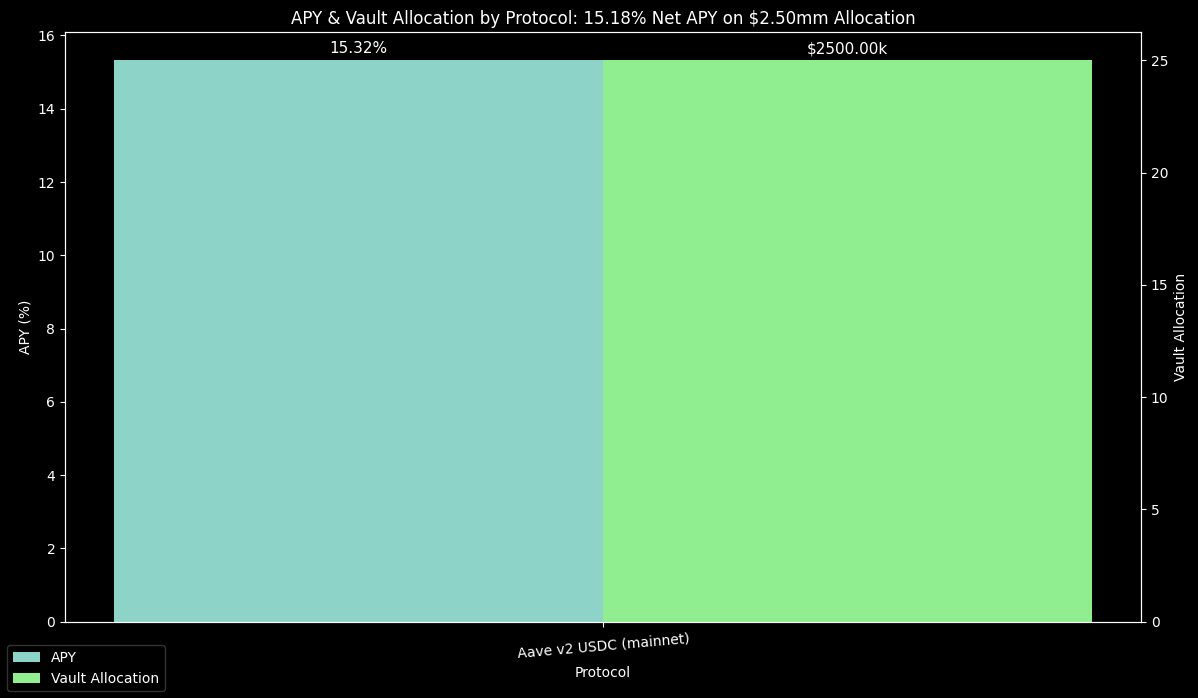

In [8]:
import matplotlib.pyplot as plt

# Plotting
plt.style.use('dark_background')
fig, ax1 = plt.subplots(figsize=(12,7))

# Calculate bar positions
n = len(df)
index = range(n)
bar_width = 0.35

# Plot APY on primary y-axis
apy_bars = ax1.bar(index, df['Current APY'], bar_width, label='APY')
ax1.set_ylabel('APY (%)')
ax1.tick_params(axis='y')

# Annotate APY bars with the value above them
for bar in apy_bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=11)

# Create a second y-axis for Vault Allocation
ax2 = ax1.twinx()
vault_allocation_bars = ax2.bar(
    [p + bar_width for p in index],
    df['Vault Allocation'],
    bar_width,
    label='Vault Allocation',
    color='lightgreen'
)
ax2.set_ylabel('Vault Allocation')
ax2.tick_params(axis='y')

# Annotate Vault Allocation bars with the value above them
for bar in vault_allocation_bars:
    height = bar.get_height()
    ax2.annotate(f'${height*1e2:.2f}k',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=11)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax1.set_xlabel('Protocol')
ax1.set_title(f'APY & Vault Allocation by Protocol: {net_apy * 100:.2f}% Net APY on {total_allocation_str} Allocation')
ax1.set_xticks([p + bar_width / 2 for p in index])
# ax1.set_xticklabels(df['Protocol Name'], rotation=15, ha='center')
ax1.set_xticklabels(
    [f"{row['Protocol Name']} ({row['Network']})" for _, row in df.iterrows()], 
    rotation=5,
    ha='center'
)

# Legend
handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles + handles2, labels + labels2, loc='lower left', framealpha=0.25)

# Display the plot
plt.tight_layout()
plt.show()